In [1]:
from I3Tray import *
from icecube import icetray, dataio, dataclasses
from icecube import phys_services
from icecube import tableio, hdfwriter
import numpy as np
import scipy
import matplotlib as mpl
import pylab
import matplotlib.pyplot as plt
import copy
import math
import sys, tables
from scipy.optimize import curve_fit
import glob
import os
from icecube import NewNuFlux
from icecube.icetray import I3Units
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

from icecube import gulliver,gulliver_modules,improvedLinefit,MuonGun, simclasses,paraboloid, dipolefit
from icecube import clast, cscd_llh, fill_ratio, tensor_of_inertia

from icecube.weighting.fluxes import Hoerandel5,GaisserH3a
from icecube.weighting import weighting

conventional = NewNuFlux.makeFlux("honda2006")
conventional.knee_reweighting_model = "gaisserH3a_elbert"

sys.path.append("/home/kevin/softwares/")
import dashi
dashi.visual()

import warnings
warnings.filterwarnings('ignore')

sys.path.append("/data/user/kevin/softwares/IceCubeMinDist/")
from ICMinDist import minDistDet

In [2]:
%matplotlib inline

In [5]:
vetoP0=np.array([-211.35,-404.48])
vetoP1=np.array([-447.74,-113.13])
vetoP2=np.array([-268.90,354.24 ])
vetoP3=np.array([-21.97,393.24])
vetoP4=np.array([54.26,292.97])
vetoP5=np.array([303.41,335.64])
vetoP6=np.array([472.05,127.90])
vetoP7=np.array([282.18,-325.74])

def LineFunc0(x,y):
    if(((vetoP1[1]-vetoP0[1])*(x-vetoP0[0]))-((y-vetoP0[1])*(vetoP1[0]-vetoP0[0]))>0):
        return 1
    else:
        return 0
def LineFunc1(x,y):
    if(((vetoP2[1]-vetoP1[1])*(x-vetoP1[0]))-((y-vetoP1[1])*(vetoP2[0]-vetoP1[0]))>0):
        return 1
    else:
        return 0
def LineFunc2(x,y):
    if(((vetoP3[1]-vetoP2[1])*(x-vetoP2[0]))-((y-vetoP2[1])*(vetoP3[0]-vetoP2[0]))>0):
        return 1
    else:
        return 0
def LineFunc3(x,y):
    if(((vetoP4[1]-vetoP3[1])*(x-vetoP3[0]))-((y-vetoP3[1])*(vetoP4[0]-vetoP3[0]))>0):
        return 1
    else:
        return 0
def LineFunc4(x,y):
    if(((vetoP5[1]-vetoP4[1])*(x-vetoP4[0]))-((y-vetoP4[1])*(vetoP5[0]-vetoP4[0]))>0):
        return 1
    else:
        return 0
def LineFunc5(x,y):
    if(((vetoP6[1]-vetoP5[1])*(x-vetoP5[0]))-((y-vetoP5[1])*(vetoP6[0]-vetoP5[0]))>0):
        return 1
    else:
        return 0
def LineFunc6(x,y):
    if(((vetoP7[1]-vetoP6[1])*(x-vetoP6[0]))-((y-vetoP6[1])*(vetoP7[0]-vetoP6[0]))>0):
        return 1
    else:
        return 0
def LineFunc7(x,y):
    if(((vetoP0[1]-vetoP7[1])*(x-vetoP7[0]))-((y-vetoP7[1])*(vetoP0[0]-vetoP7[0]))>0):
        return 1
    else:
        return 0

def InOrOut(x,y):
    return LineFunc0(x,y)&LineFunc1(x,y)&LineFunc2(x,y)&LineFunc5(x,y)&LineFunc6(x,y)&LineFunc7(x,y)&((LineFunc3(x,y)|LineFunc4(x,y)))


def MCStarting_polygon(x,y,z):
    p=np.array([x,y,z])
    if((p[2]<470)&(p[2]>-440)):
        if(InOrOut(p[0],p[1])):
            return 1
    return 0


Class of datasets which we load events' inforamtion in:

In [3]:
class dataset:
    def __init__(self):
        self.zenith=np.array([])
        self.relevant_energy=np.array([])
        self.ptype=np.array([])
        self.MCenergy=np.array([])
        self.MCMu=np.array([])
        self.MCzenith=np.array([])
        self.OneWeight=np.array([])
        self.weight=np.array([])
        self.MCneutrinoEnergy=np.array([])
        self.MCPrimary=np.array([])
        self.MCCascade=np.array([])
        self.totQ=np.array([])
        self.decisionFunction=np.array([])
        self.weight1yr=np.array([])
        self.MuonEnergy_splined_millipede=np.array([])
        self.cascadeEnergy_millipede=np.array([])
        self.dEdx_millipede=np.array([])
        self.px=np.array([])
        self.py=np.array([])
        self.pz=np.array([])
        self.pcx=np.array([])
        self.pcy=np.array([])
        self.pcz=np.array([])
        self.NeutrinoEnergy_splined_millipede=np.array([])
        self.MCTrue=np.array([])
        self.MCTrue_polygon=np.array([])
        self.NeutrinoEnergy_adaboost=np.array([])

Importing processed and weighted NuFSGen data:

In [4]:
count=0
file_list=["/data/user/kevin/sterile/startingTrack/data/compare/NuSelection_NuFSGen_LE_L5_st90.dat",
           "/data/user/kevin/sterile/startingTrack/data/compare/NuSelection_NuFSGen_HE_L5_st90.dat"]

nufsgen_st = dataset()

for file in file_list:
    #f=glob.glob(file)
    t=np.loadtxt(file)
    count+=1
    nufsgen_st.weight1yr=np.append(nufsgen_st.weight1yr,t[:,4])
    nufsgen_st.MCzenith=np.append(nufsgen_st.MCzenith,t[:,1])
    nufsgen_st.MCPrimary=np.append(nufsgen_st.MCPrimary,t[:,3])
    nufsgen_st.MCCascade=np.append(nufsgen_st.MCCascade,t[:,8])
    nufsgen_st.zenith=np.append(nufsgen_st.zenith,t[:,6])
    #nufsgen_st.relevant_energy=np.append(nufsgen_st.relevant_energy,t[:,5])
    nufsgen_st.MCneutrinoEnergy=np.append(nufsgen_st.MCneutrinoEnergy,t[:,9])
    nufsgen_st.ptype=np.append(nufsgen_st.ptype,t[:,0])
    nufsgen_st.MCTrue=np.append(nufsgen_st.MCTrue,t[:,10])
    nufsgen_st.px=np.append(nufsgen_st.px,t[:,11])
    nufsgen_st.py=np.append(nufsgen_st.py,t[:,12])
    nufsgen_st.pz=np.append(nufsgen_st.pz,t[:,13])
    nufsgen_st.pcx=np.append(nufsgen_st.pcx,t[:,27])
    nufsgen_st.pcy=np.append(nufsgen_st.pcy,t[:,28])
    nufsgen_st.pcz=np.append(nufsgen_st.pcz,t[:,29])
    nufsgen_st.MuonEnergy_splined_millipede=np.append(nufsgen_st.MuonEnergy_splined_millipede,t[:,24])
    nufsgen_st.dEdx_millipede=np.append(nufsgen_st.dEdx_millipede,t[:,23])
    nufsgen_st.NeutrinoEnergy_splined_millipede=np.append(nufsgen_st.NeutrinoEnergy_splined_millipede,t[:,25])
    nufsgen_st.cascadeEnergy_millipede=np.append(nufsgen_st.cascadeEnergy_millipede,t[:,26])
    nufsgen_st.NeutrinoEnergy_adaboost=np.append(nufsgen_st.NeutrinoEnergy_adaboost,t[:,30])
    print(str(count)+' nufsgen files loaded')
    del t

1 nufsgen files loaded
2 nufsgen files loaded


Calculating missing properties:

In [7]:
# Cascade minDist
nufsgen_st.minDistDetCas = np.zeros_like(nufsgen_st.px)
for i in range(len(nufsgen_st.minDistDetCas)):
    nufsgen_st.minDistDetCas[i] = minDistDet(nufsgen_st.pcx[i], nufsgen_st.pcy[i],nufsgen_st.pcz[i])

In [8]:
# Cascade True minDist
nufsgen_st.minDistDet=np.zeros_like(nufsgen_st.px)
for i in range(len(nufsgen_st.minDistDet)):
    nufsgen_st.minDistDet[i] = minDistDet(nufsgen_st.px[i], nufsgen_st.py[i],nufsgen_st.pz[i])

MinDist is the distance of a point (in this case the cascade) from the borders of the detector (in 3 dimensions).
Image below shows the MinDist in the x-y plane.

<img src="imgs/ic_minDist.png" style="width: 400px;"/>

It is clear the deeper the minDist cut the more pure the starting tracks are, but we will pay by statistics. Plot below shows the purity and number of events vs. minDist cut.

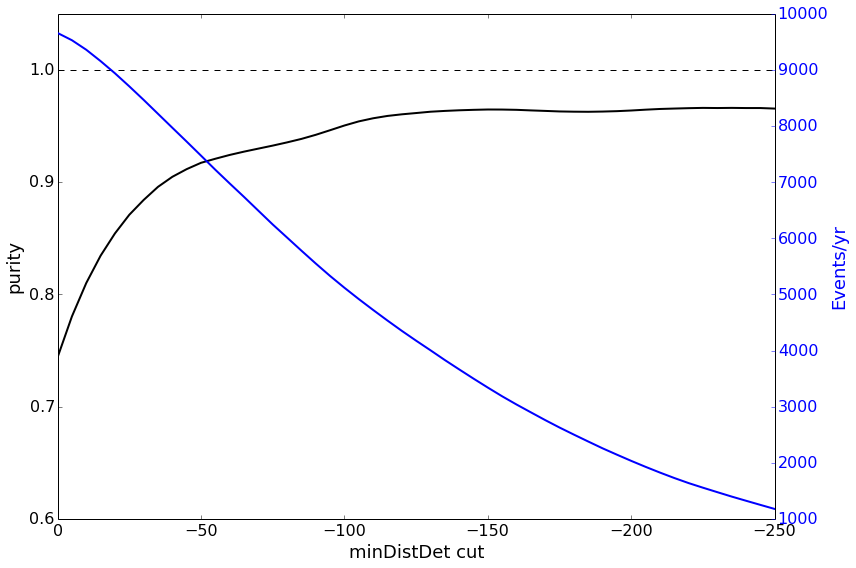

In [159]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax1.plot([0,-250],[1,1],'k--')
ax1.plot(Dist,Purity,'k',linewidth=2)
ax1.set_xlabel('minDistDet cut',fontsize=18)
ax1.set_ylabel('purity',fontsize=18,color='k')
ax1.tick_params('y', colors='k')
ax1.set_ylim(0.6,1.05)
ax1.set_xlim(0,-250)

ax2=ax1.twinx()
ax2.plot(Dist,Events,'b',linewidth=2)
ax2.set_ylabel('Events/yr',fontsize=18,color='b')
ax2.tick_params('y', colors='b')

ax1.tick_params(axis='both',which='major',labelsize=16)
ax2.tick_params(axis='both',which='major',labelsize=16)

fig.tight_layout()


But there's a strong dependence on the energy of the cascade. Plot below shows the purity as a function of energy for different minDist cuts. And the plot bellow that shows the histogram of the events for each cut.

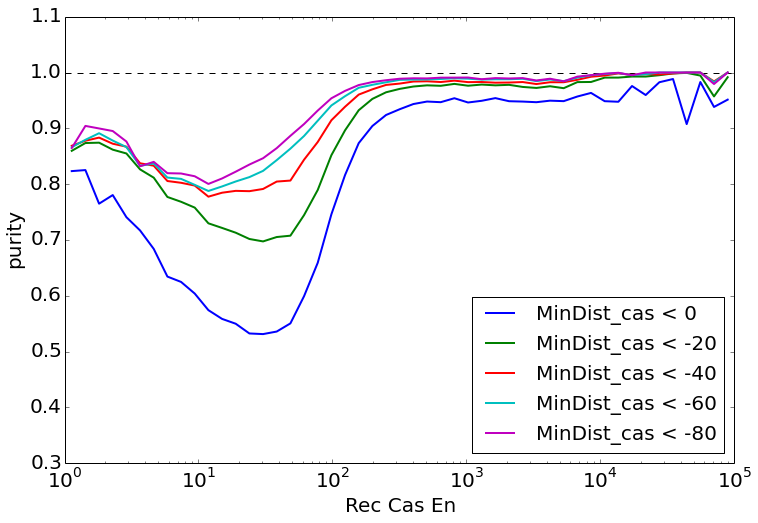

In [31]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(0, 5, 50)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

plt.plot([1e0, 1e5], [1, 1], 'k--')


for i in [0, -20, -40, -60, -80]:
    def Filter(dset): return (dset.minDistDetCas < i)
    filterAll = Filter(nufsgen_st)

    def Filter(dset): return (dset.minDistDet < 0) & (dset.minDistDetCas < i)
    filter = Filter(nufsgen_st)

    h0 = np.histogram(
        nufsgen_st.cascadeEnergy_millipede[filterAll],
        weights=nufsgen_st.weight1yr[filterAll],
        bins=bins)
    h1 = np.histogram(
        nufsgen_st.cascadeEnergy_millipede[filter],
        weights=nufsgen_st.weight1yr[filter],
        bins=bins)
    plt.plot(bins_center, h1[0] / h0[0],
             label='MinDist_cas < ' + str(i), linewidth=2)


plt.xlim(1e0, 1e5)
plt.ylim(0.3, 1.1)
plt.legend(fontsize=20, loc=4)
plt.xlabel('Rec Cas En', fontsize=20)
plt.ylabel('purity', fontsize=20)
plt.semilogx()
plt.tick_params(axis='both', which='major', labelsize=20)

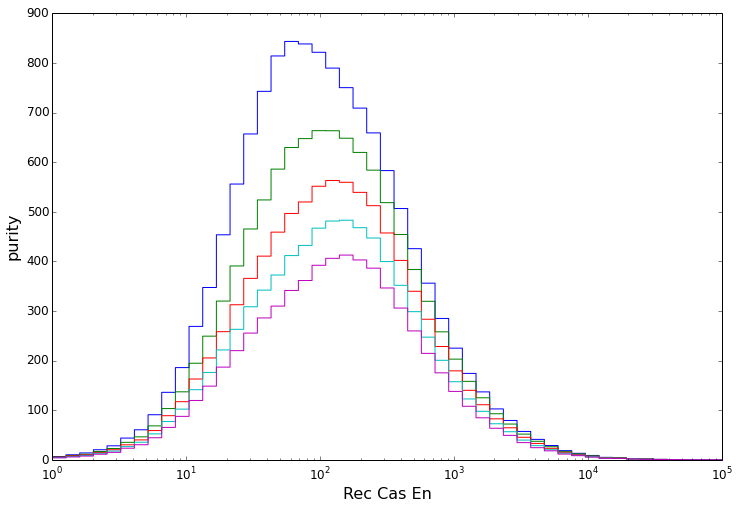

In [166]:
fig = plt.figure(figsize=(12,8))

bins=np.logspace(0,5,50)
bins_center = [ (bins[i]+bins[i+1])/2 for i in range(len(bins)-1) ]

for i in [0,-20,-40,-60,-80]:
    Filter = lambda dset:(dset.minDistDetCas<i)
    filterAll=Filter(nufsgen_st)
    Filter = lambda dset:(dset.minDistDet<0)&(dset.minDistDetCas<i)
    filter=Filter(nufsgen_st)

    plt.hist(nufsgen_st.cascadeEnergy_millipede[filterAll], weights=nufsgen_st.weight1yr[filterAll],bins=bins,
             histtype='step')


plt.xlim(1e0,1e5)
#plt.ylim(0,1.2)
plt.legend(fontsize=12)
plt.xlabel('Rec Cas En',fontsize=16)
plt.ylabel('purity',fontsize=16)
plt.semilogx()
plt.tick_params(axis='both',which='major',labelsize=12)


The most efficient way to get a very pure dataset with high number of events per year, is to train the machine to select the starting events.

In [12]:
# loading sklearn modules
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from matplotlib.colors import Normalize
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

This selection is based on the minDist of the started cascde (reconstructed), reconstructed cascade energy, and dE/dx of the muon track.

In [16]:
X = np.column_stack((nufsgen_st.cascadeEnergy_millipede,
                     nufsgen_st.dEdx_millipede))
X = np.column_stack((X, nufsgen_st.minDistDetCas))

# event weights
w = nufsgen_st.weight1yr

# true cascade location (in simulations)
# determines truly starting tracks
y = nufsgen_st.minDistDet < 0

In [17]:
# splitting events
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,
                                                                     y,
                                                                     w,
                                                                     test_size=.1,
                                                                     random_state=42)

In [70]:
# defining classifier
clf = AdaBoostClassifier()

# fitting data
clf.fit(X_train, y_train, sample_weight=w_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Writing down the results on disk:

In [206]:
# comment out to avoid overwriting
# joblib.dump(clf, 'DataSelection/Starting_2012_clf_AdaBoost_3vars/Starting_2012_clf_AdaBoost_3vars_v1.pkl')

In [13]:
# loading classifier
clf = joblib.load('DataSelection/Starting_2012_clf_AdaBoost_3vars/Starting_2012_clf_AdaBoost_3vars_v1.pkl')

In [18]:
# cacluating the decision functions
decisionFunc_test = clf.decision_function(X_test)
decisionFunc_all = clf.decision_function(X)

In [19]:
# write down the dicision function in their dataset class
nufsgen_st.df_st = decisionFunc_all

This plot shows how good the classifier can separated the strarting vs. through-going tracks.

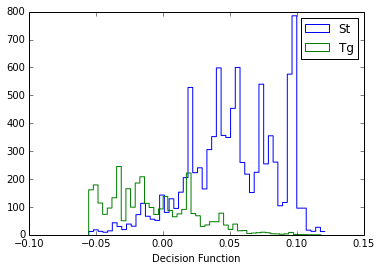

In [114]:
bins = 20

null = plt.hist(decisionFunc_test[y_test == 1],
                weights=w_test[y_test == 1],
                bins=bins,
                histtype='step',
                normed=False,
                label='St')

null = plt.hist(decisionFunc_test[y_test == 0],
                weights=w_test[y_test == 0],
                bins=bins,
                histtype='step',
                normed=False,
                label='Tg')

plt.legend()
plt.xlabel('Decision Function')

The higher the decision function cut the better the purity but less statistics.

In [135]:
lim = []
pur = []
evn = []
for i in np.linspace(-0.06,0.13,100):
    __sC = sum(w[(y==1) & (d_all>i)])
    __tC = sum(w[(y==0) & (d_all>i)])
    if (__sC or __tC):
        lim.append(i)
        evn.append(__sC+__tC)
        pur.append(__sC*1./(__sC+__tC))
    else:
        break

In [195]:
limBS = []
evnBS = []
for i in np.linspace(-0.06,0.13,100):
    __sC = len(d_bs_all[d_bs_all>i])
    if (__sC):
        limBS.append(i)
        evnBS.append(__sC)
    else:
        break

In [152]:
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker

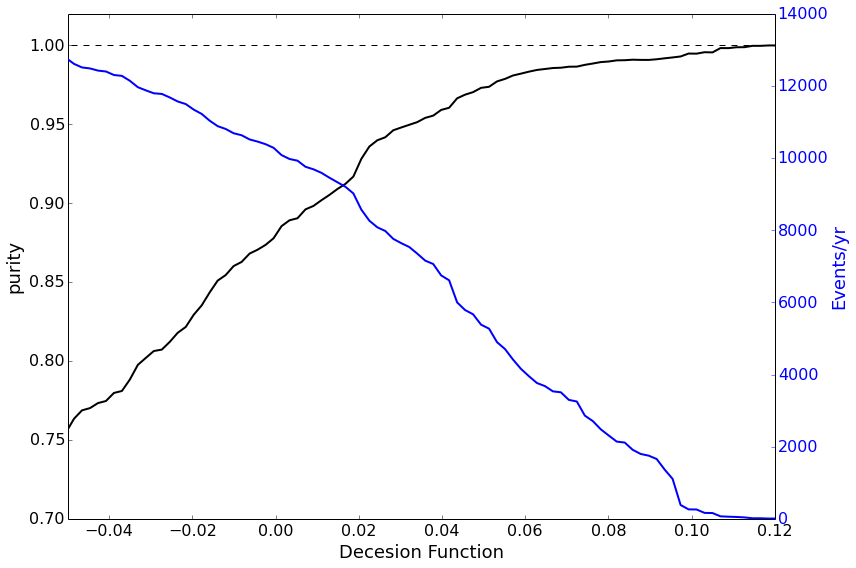

In [158]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot([-.1, .15], [1, 1], 'k--')
ax1.plot(lim, pur, 'k', linewidth=2)
ax1.set_xlabel('Decesion Function', fontsize=18)
ax1.set_ylabel('purity', fontsize=18, color='k')
ax1.tick_params('y', colors='k')
ax1.set_ylim(0.7, 1.02)
ax1.set_xlim(-.05, 0.12)

ax2 = ax1.twinx()
ax2.plot(lim, evn, 'b', linewidth=2)
ax2.set_ylabel('Events/yr', fontsize=18, color='b')
ax2.tick_params('y', colors='b')
ax2.set_xlim(-.05, 0.12)

# this locator puts ticks at regular intervals
loc = plticker.MultipleLocator(base=.02)
ax2.xaxis.set_major_locator(loc)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

However the plot aboves shows that we can reach higher purities and statistics compared to just having a minDist cut.

The best way to determine if there's overfitting is to compare the simulations with real experimental data.
In plot below we user 10% burnsample (10% of real data randomly selected for test and will never be used in the final analysis). And they agree with each other pretty well. Data should be mix of (i.e. sum of) starting and through-going events.

In [188]:
filter = [bs_st.minDistDetCas < 0]

X_bs = np.column_stack(
    (bs_st.cascadeEnergy_millipede[filter],
     bs_st.dEdx_millipede[filter]))
X_bs = np.column_stack((X_bs, bs_st.minDistDetCas[filter]))

d_bs_all = clf.decision_function(X_bs)

In [25]:
def Error(x):
    """
    Gives the statistical error of the x
    """
    __err = np.sqrt(x)
    # 1 +/- 1 cannot be plottd in log plot
    # so taking taking a small amout from err
    # to be plotted properly
    for i in range(len(x)):
        if x[i] == 1:
            __err[i] = 1 - 1e-10
    return __err

(0, 120)

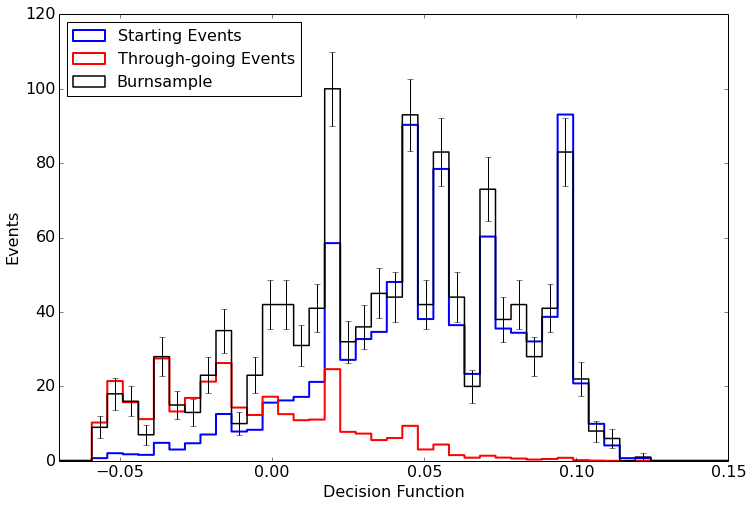

In [418]:
fig = plt.figure(figsize=(12, 8))

bins = np.linspace(-0.1, .15, 50)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

w_ = np.divide(w, (365.25 * 24 * 3600) / BSLiveTime / 1.07)
null = plt.hist(d_all[y == 1], weights=w_[y == 1],
                bins=bins,
                histtype='step',
                linewidth=2,
                normed=False,
                label='Starting Events')
null = plt.hist(d_all[y == 0], weights=w_[y == 0],
                bins=bins,
                histtype='step',
                linewidth=2,
                normed=False,
                label='Through-going Events',
                color='r')

null = plt.hist(d_bs_all,
                bins=bins,
                histtype='step',
                linewidth=1.5,
                normed=False,
                label='Burnsample',
                color='k')
hist = np.histogram(d_bs_all,
                    bins=bins)
plt.errorbar(bins_center, hist[0],
             yerr=Error(hist[0]),
             fmt=None,
             ecolor='k')

plt.legend(fontsize=16, loc=2)
plt.xlabel('Decision Function', fontsize=16)
plt.ylabel('Events', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.xlim(-.07, .15)
plt.ylim(0, 120)

Events per year as a function of decision function cut plot also agrees in simulation and experimental data.

In [185]:
BSLiveTime = 2818225.47 # seconds of burnsample data (about 32 days in this year)

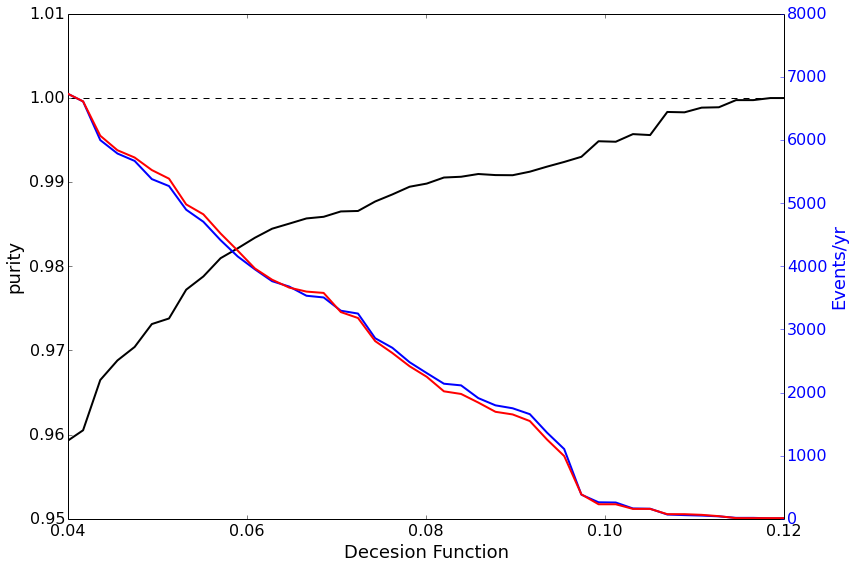

In [201]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot([-.1, .15], [1, 1], 'k--')
ax1.plot(lim, pur, 'k', linewidth=2)
ax1.set_xlabel('Decesion Function', fontsize=18)
ax1.set_ylabel('purity', fontsize=18, color='k')
ax1.tick_params('y', colors='k')
ax1.set_ylim(0.95, 1.01)
ax1.set_xlim(0.04, 0.12)

ax2 = ax1.twinx()
ax2.plot(lim, evn, 'b', linewidth=2)
ax2.set_ylabel('Events/yr', fontsize=18, color='b')
ax2.tick_params('y', colors='b')
ax2.set_xlim(.04, 0.12)
ax2.set_ylim(0, 8000)

ax2.plot(
    limBS,
    np.multiply(
        evnBS,
        (365.25 * 24 * 3600) / BSLiveTime / 1.07),
    'r',
    linewidth=2)


# this locator puts ticks at regular intervals
loc = plticker.MultipleLocator(base=.02)
ax2.xaxis.set_major_locator(loc)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

Plot above:
<br>
Red: event numbers (experimental data / burnsample)
<br>
Blue: event numbers (simulation)
<br>
Black: purity (simulation)
<br>
*we cannot plot the purity for experimental data since we don't know if the events are truly starting or now.

Plotting the neutrino reconstructed energy histogram for both simulation and experimental data (32 day burnsample) with 99% starting trak purity i.e. decision function < 0.08
<br>
They agree with each other.

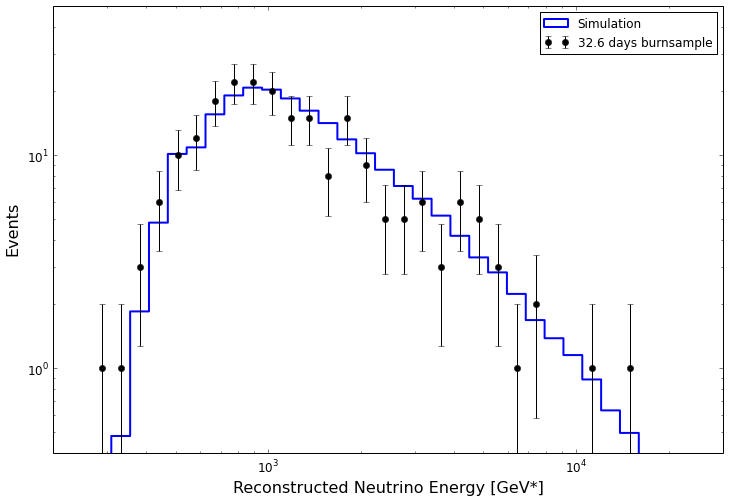

In [299]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(2, 5, 50)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]


def Filter(dset): return (dset.df_st > 0.08) &\
    (dset.NeutrinoEnergy_splined_millipede < 2e4)

# Simulation
filter = Filter(nufsgen_st)

plt.hist(nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
         weights=np.divide(
    nufsgen_st.weight1yr[filter],
    (365.25 * 24 * 3600) / BSLiveTime / 1.075518),
    bins=bins,
    histtype='step',
    linewidth=2,
    label='Simulation')

# Data
filter = Filter(bs_st)

hist = np.histogram(bs_st.NeutrinoEnergy_splined_millipede[filter],
                    bins=bins)
plt.errorbar(bins_center, hist[0],
             yerr=Error(hist[0]),
             fmt='o',
             color='k',
             label='32.6 days burnsample')


plt.xlim(2e2, 3e4)
plt.ylim(4e-1, 50)
plt.legend(fontsize=12)
plt.xlabel('Reconstructed Neutrino Energy [GeV*]', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.loglog()
plt.tick_params(axis='both', which='major', labelsize=12)

In [26]:
def Filter(dset): return (dset.df_st > 0.0) &\
    (dset.NeutrinoEnergy_splined_millipede < 2e4)
filter = Filter(bs_st)

bsEvnts = len(bs_st.NeutrinoEnergy_splined_millipede[filter])
print('Events in burnsample : ' + str(bsEvnts))
print('Events per year of data : '+ str(int(bsEvnts * 365.25 * 24 * 3600 / BSLiveTime)))

Events in burnsample : 215
Events per year of data : 2407


Plotting the neutrino reconstructed energy histogram for both simulation and experimental data (32 day burnsample) with 90% starting trak purity i.e. decision function < 0.0
<br>
They agree with each other.

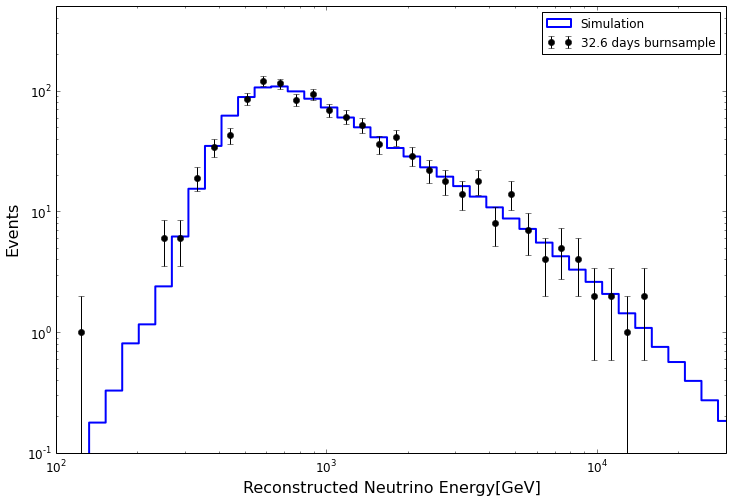

In [250]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(2, 5, 50)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]


def Filter(dset): return (dset.df_st > 0.0) &\
    (dset.NeutrinoEnergy_splined_millipede < 2e4)


# Simulation
filter = Filter(nufsgen_st)

plt.hist(nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
         weights=np.divide(
    nufsgen_st.weight1yr[filter],
    (365.25 * 24 * 3600) / BSLiveTime / 1.17545),
    bins=bins,
    histtype='step',
    linewidth=2,
    label='Simulation')

# Data
filter = Filter(bs_st)

hist = np.histogram(bs_st.NeutrinoEnergy_splined_millipede[filter],
                    bins=bins)
plt.errorbar(bins_center, hist[0],
             yerr=Error(hist[0]),
             fmt='o',
             color='k',
             label='32.6 days burnsample')

plt.xlim(1e2, 3e4)
plt.ylim(1e-1, 5e2)
plt.legend(fontsize=12)
plt.xlabel('Reconstructed Neutrino Energy[GeV]', fontsize=16)
plt.ylabel('Events', fontsize=16)
plt.loglog()
plt.tick_params(axis='both', which='major', labelsize=12)

In [27]:
def Filter(dset): return (dset.df_st > 0.0) &\
    (dset.NeutrinoEnergy_splined_millipede < 2e4)
filter = Filter(bs_st)

bsEvnts = len(bs_st.NeutrinoEnergy_splined_millipede[filter])
print('Events in burnsample : ' + str(bsEvnts))
print('Events per year of data : '+ str(int(bsEvnts * 365.25 * 24 * 3600 / BSLiveTime)))

Events in burnsample : 1018
Events per year of data : 11399


We can calculate the energy resolution of the truly starting tracks.

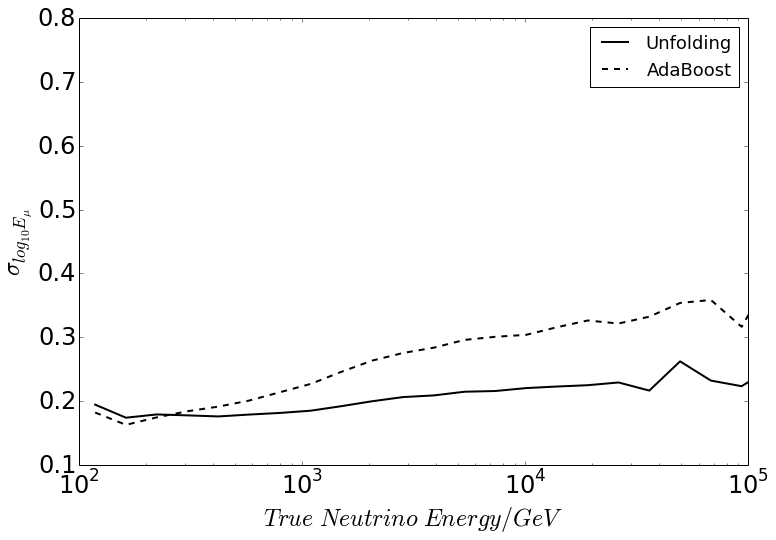

In [221]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(2, 6, 30)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]


def Filter(dset): return (dset.minDistDet < 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='Unfolding',
                linewidth=2,
                color='k',
                linestyle='-'
                )


def Filter(dset): return (dset.minDistDet < 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_adaboost[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='AdaBoost',
                linewidth=2,
                color='k',
                linestyle='--'
                )


plt.xlim(1e2, 1e5)
plt.ylim(.1, .8)
plt.legend(fontsize=18)
plt.xlabel(r'$True\ Neutrino\ Energy/GeV$', fontsize=24)
plt.ylabel(r'$\sigma_{log_{10}E_{\mu}}$', fontsize=24)
plt.semilogx()
plt.tick_params(axis='both', which='major', labelsize=24)

Comparing TRUE neurino energy resolution of 90 and 99 percent starting track purity at level 5.
<br>
Raise of L5st99 at low energies is due to lack of statistics.

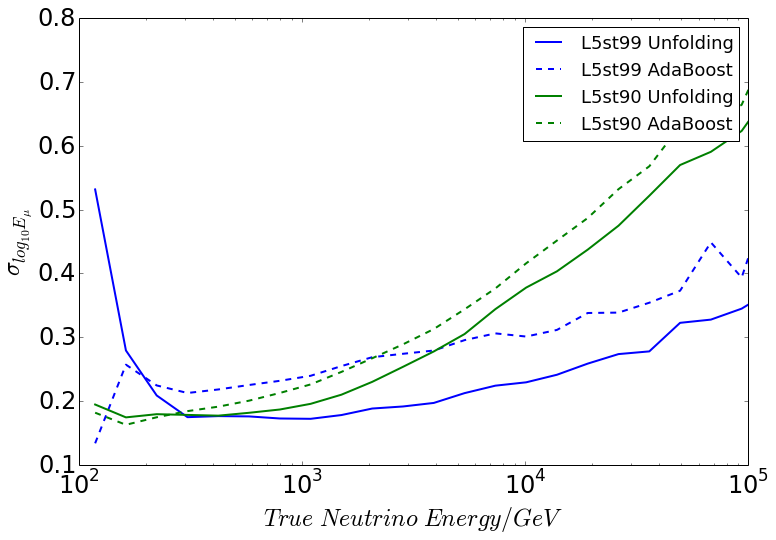

In [220]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(2, 6, 30)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]


def Filter(dset): return (dset.df_st > 0.08)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp, label='L5st99 Unfolding', linewidth=2,
                color='b',
                linestyle='-'
                )


def Filter(dset): return (dset.df_st > 0.08)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_adaboost[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st99 AdaBoost',
                linewidth=2,
                color='b',
                linestyle='--'
                )


def Filter(dset): return (dset.df_st > 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st90 Unfolding',
                linewidth=2,
                color='g',
                linestyle='-'
                )


def Filter(dset): return (dset.df_st > 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.NeutrinoEnergy_adaboost[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st90 AdaBoost',
                linewidth=2,
                color='g',
                linestyle='--'
                )


plt.xlim(1e2, 1e5)
plt.ylim(.1, .8)
plt.legend(fontsize=18)
plt.xlabel(r'$True\ Neutrino\ Energy/GeV$', fontsize=24)
plt.ylabel(r'$\sigma_{log_{10}E_{\mu}}$', fontsize=24)
plt.semilogx()
plt.tick_params(axis='both', which='major', labelsize=24)

Comparing RECONSTRUCTED neurino energy resolution of 90 and 99 percent starting track purity at level 5.
<br>
Fluctuation of L5st99 at low energies is due to lack of statistics.

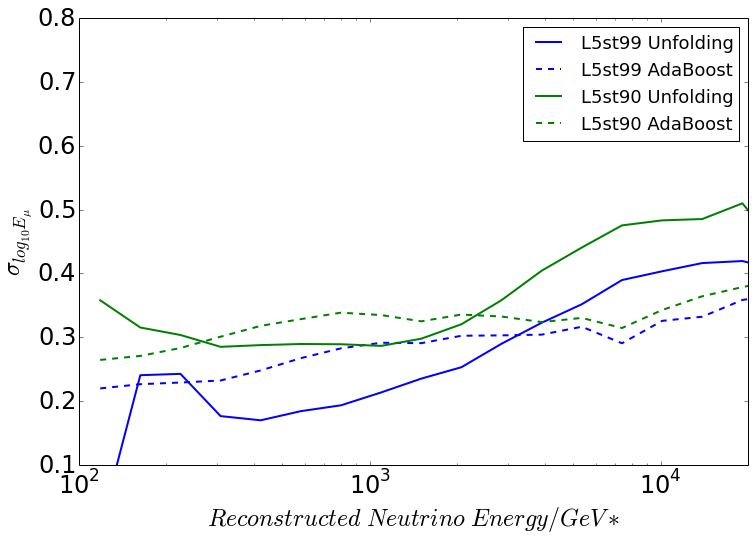

In [217]:
fig = plt.figure(figsize=(12, 8))

bins = np.logspace(2, 6, 30)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]


def Filter(dset): return (dset.df_st > 0.08)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                 nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st99 Unfolding',
                linewidth=2,
                color='b',
                linestyle='-'
                )


def Filter(dset): return (dset.df_st > 0.08)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.NeutrinoEnergy_adaboost[filter],
                 nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st99 AdaBoost',
                linewidth=2,
                color='b',
                linestyle='--'
                )


def Filter(dset): return (dset.df_st > 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                 nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st90 Unfolding',
                linewidth=2,
                color='g',
                linestyle='-'
                )


def Filter(dset): return (dset.df_st > 0.0)
filter = Filter(nufsgen_st)

tmp = resolution(nufsgen_st.NeutrinoEnergy_adaboost[filter],
                 nufsgen_st.MCneutrinoEnergy[filter],
                 nufsgen_st.weight1yr[filter],
                 bins)
null = plt.plot(bins_center, tmp,
                label='L5st90 AdaBoost',
                linewidth=2,
                color='g',
                linestyle='--'
                )


plt.xlim(1e2, 2e4)
plt.ylim(.1, .8)
plt.legend(fontsize=18)
plt.xlabel(r'$Reconstructed\ Neutrino\ Energy/GeV*$', fontsize=24)
plt.ylabel(r'$\sigma_{log_{10}E_{\mu}}$', fontsize=24)
plt.semilogx()
plt.tick_params(axis='both', which='major', labelsize=24)

Energy histogram of the truly starting track in L5st99:

[]

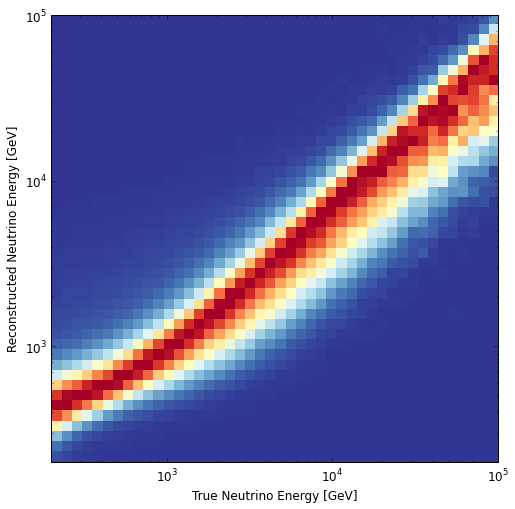

In [213]:
fig, ax = plt.subplots(figsize=[8, 8])
xbins = np.logspace(2, 5, 50)
ybins = np.logspace(2, 5, 50)

def Filter(dset): return (dset.df_st > 0.0) & (dset.minDistDet < 0.0)


filter = Filter(nufsgen_st)

hist = dashi.factory.hist2d((nufsgen_st.MCneutrinoEnergy[filter],
                             nufsgen_st.NeutrinoEnergy_splined_millipede[filter]),
                             bins=(xbins, ybins))

# color normalization vertically
for i in range(len(hist.bincontent)):
    # den=sum(hist.bincontent[i])
    den = max(hist.bincontent[i])
    for j in range(len(hist.bincontent[i])):
        hist.bincontent[i][j] /= (den * 1.)

hist.imshow(norm=mpl.colors.Normalize(), cmap=mpl.cm.RdYlBu_r)

plt.xlim(2e2, 1e5)
plt.ylim(2e2, 1e5)

plt.xlabel('True Neutrino Energy [GeV]', fontsize=12)
plt.ylabel('Reconstructed Neutrino Energy [GeV]', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.loglog()

Comparison of the ice model systematics error with the statistical error:

In [608]:
def SysErrorComparison(x0, y0, w0,
                       x1, y1, w1,
                       bins,
                       vmin=None, vmax=None,
                       colorbar_label=None,
                       title=None):
    """
    2-D plot of the comparison between a systematic set
    error and the statistical error of the main data set
    x, y: x and y axes
    sub 0: main dataset
    sub 1: systematic dataset
    w: weights
    bins: bins
    vmin, vmax: color normalization of the plot
    colorbar_label: colorbar label
    title: plot title
    """
    Hist0 = np.histogram2d(np.log10(x0), y0,
                           bins=bins,
                           weights=w0
                           )
    Hist0_normed = np.histogram2d(np.log10(x0), y0,
                                  bins=bins,
                                  weights=np.divide(w0, sum(w0)),
                                  )
    Hist1_normed = np.histogram2d(np.log10(x1), y1,
                                  bins=bins,
                                  weights=np.divide(w1, sum(w1)),
                                  )

    x = Hist0[1]
    y = Hist0[2]
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(Hist0[0])
    for i in range(len(x) - 1):
        for j in range(len(y) - 1):
            Z[i][j] = (((Hist1_normed[0][i][j] - Hist0_normed[0][i][j])
                        * 1. / Hist0_normed[0][i][j])) / np.sqrt(Hist0[0][i][j])
            # Z[i][j] = ((Hist1_normed[0][i][j] - Hist0_normed[0][i][j]) * 1. / Hist0_normed[0][i][j])

    Z = np.swapaxes(Z, 0, 1)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.pcolor(Y, X, Z, cmap='RdBu', norm=Normalize(vmin=vmin, vmax=vmax))
    plt.axis([Y.min(), Y.max(), X.min(), X.max()])
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.xlabel(r'$cos(Zenith_{rec})$', fontsize=24)
    plt.ylabel(r'$log_{10}(E_{\nu,rec}/GeV)$', fontsize=24)
    cb = plt.colorbar(label=colorbar_label)
    cb.ax.tick_params(labelsize=18)
    text = cb.ax.yaxis.label
    font = mpl.font_manager.FontProperties(size=18)
    text.set_font_properties(font)
    ax.set_title(title, fontsize=20)

    shiftX = (bins[0][1] - bins[0][0]) / 2.
    shiftY = (bins[1][1] - bins[1][0]) / 2.
    for py in range(Z.shape[0]):
        for px in range(Z.shape[1]):
            plt.text(Y[py][0] + shiftY, X[0][px] + shiftX, '%.4f' % Z[py, px],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

    # plt.xlim(-1,0)

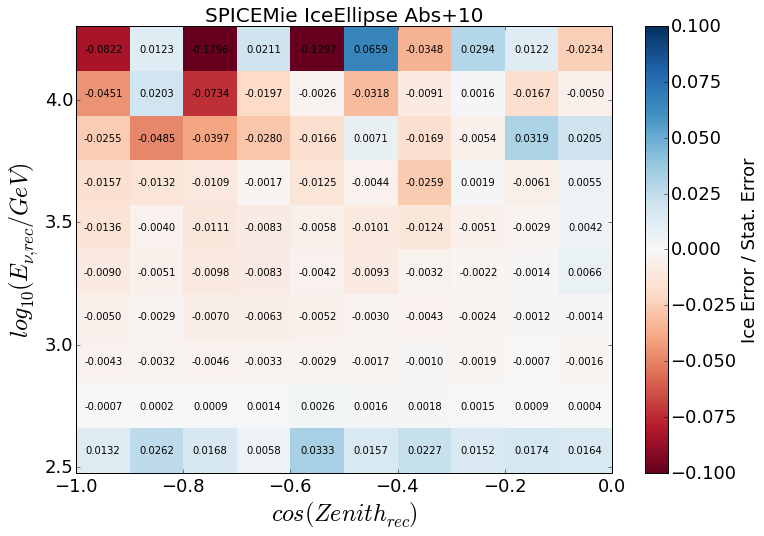

In [606]:
SysErrorComparison(x0=nufsgen_sys0.NeutrinoEnergy_splined_millipede,
                   y0=np.cos(nufsgen_sys0.zenith),
                   w0=nufsgen_sys0.weight1yr,
                   x1=nufsgen_sys1.NeutrinoEnergy_splined_millipede,
                   y1=np.cos(nufsgen_sys1.zenith),
                   w1=nufsgen_sys1.weight1yr,
                   bins=[np.linspace(np.log10(3e2),np.log10(2e4),11),np.linspace(-1,0,11)],
                   vmin=-.1,
                   vmax=.1,
                   colorbar_label='Ice Error / Stat. Error',
                   title='SPICEMie IceEllipse Abs+10',
                  )

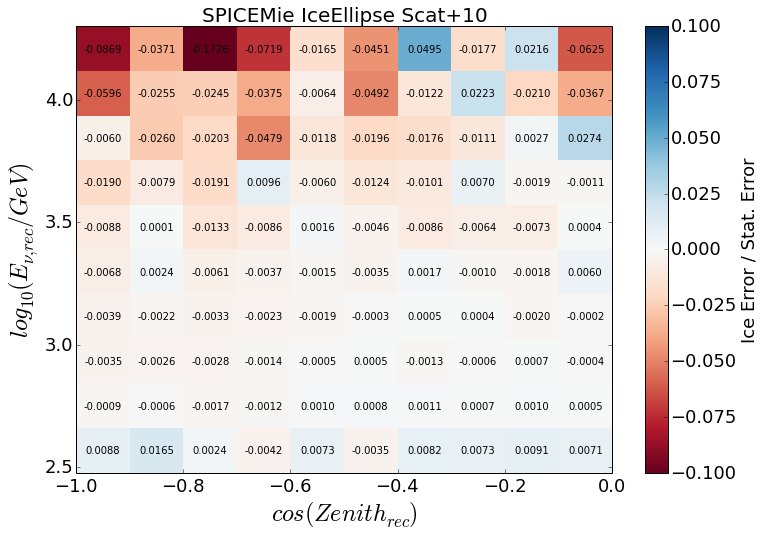

In [607]:
SysErrorComparison(x0=nufsgen_sys0.NeutrinoEnergy_splined_millipede,
                   y0=np.cos(nufsgen_sys0.zenith),
                   w0=nufsgen_sys0.weight1yr,
                   x1=nufsgen_sys2.NeutrinoEnergy_splined_millipede,
                   y1=np.cos(nufsgen_sys2.zenith),
                   w1=nufsgen_sys2.weight1yr,
                   bins=[np.linspace(np.log10(3e2),np.log10(2e4),11),np.linspace(-1,0,11)],
                   vmin=-.1,
                   vmax=.1,
                   colorbar_label='Ice Error / Stat. Error',
                   title='SPICEMie IceEllipse Scat+10',
                  )